# Практическая работа №2

In [ ]:
# Импортируем основные модули pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Импортируем модули, связанные с компьютерным зрением
from torchvision import datasets
from torchvision.transforms import ToTensor

# Импортируем вспомогательные модули
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Если графический ускоритель поддерживает обучение на нем, будем использовать его,
# иначе обучать на процессоре.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device, torch.cuda.get_device_name()

('cuda', 'Tesla K80')

# Часть 1. Полносвязная НС

В данной лабораторной работе вам необходимо обучить две сети с архитектурой, которую вам необходимо разработать самостоятельно.
В этой части предлагается реализовать полносвязную сеть без использования сверточных слоев.

Поэкспериментируйте с использованием слоев пакетной нормализации и дропаута.

Сравните точность на тестовой выборке с аналогичными результатами одногруппников.

In [ ]:
class FCNet(nn.Module):

  def __init__(self):
    super().__init__()

    # ВАШ КОД ЗДЕСЬ
    self.classifier = nn.Sequential(
      nn.Linear(32 * 32 * 3, 512),
      nn.BatchNorm1d(512),
      nn.ReLU(),

      nn.Linear(512, 256),
      nn.BatchNorm1d(256),            
      nn.Dropout(p=0.35),
      nn.ReLU(),

      nn.Linear(256, 128),
      nn.BatchNorm1d(128),
      nn.ReLU(),

      nn.Linear(128, 64),
      nn.BatchNorm1d(64),            
      nn.Dropout(p=0.35),
      nn.ReLU(),

      nn.Linear(64, 10),
      # nn.ReLU(),
    )
    # ===============

  def forward(self, x):
    # ВАШ КОД ЗДЕСЬ
    x = x.view(-1, 32*32*3)
    return self.classifier(x)
    # ===============

In [ ]:
# Задаем количество эпох (проходов по всей обучающей выборке) и размер пакета, можно варьировать
EPOCHS = 10
BATCH_SIZE = 512

In [ ]:
# Загружаем данные из набора CIFAR10
train_data = datasets.CIFAR10(root='../data/CIFAR10/train', train=True, download=True, transform=ToTensor())
test_data = datasets.CIFAR10(root='../data/CIFAR10/test', train=False, download=True, transform=ToTensor())

# DataLoader позволяет разбить выборку на пакеты заданного размера.
# Параметр shuffle отвечает за перемешивание данных в пакете
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# Готовимся к обучению
model = FCNet().to(device)  # создаем модель
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # оптимизатор, нужно выбрать и настроить
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()  # функция потерь, нужно выбрать
loss_history = list()  # список для хранения истории изменения функции стоимости

Эпоха 1 завершилась с функцией стоимости на последнем пакете = 1.7258985042572021
Эпоха 2 завершилась с функцией стоимости на последнем пакете = 1.5091475248336792
Эпоха 3 завершилась с функцией стоимости на последнем пакете = 1.4172292947769165
Эпоха 4 завершилась с функцией стоимости на последнем пакете = 1.3692189455032349
Эпоха 5 завершилась с функцией стоимости на последнем пакете = 1.2613637447357178
Эпоха 6 завершилась с функцией стоимости на последнем пакете = 1.252396583557129
Эпоха 7 завершилась с функцией стоимости на последнем пакете = 1.139272689819336
Эпоха 8 завершилась с функцией стоимости на последнем пакете = 1.1937018632888794
Эпоха 9 завершилась с функцией стоимости на последнем пакете = 1.0980134010314941
Эпоха 10 завершилась с функцией стоимости на последнем пакете = 1.0037649869918823


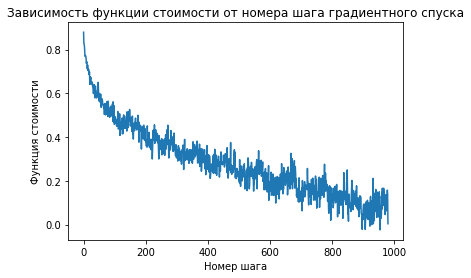

In [ ]:
# Начинаем обучение
for epoch in range(EPOCHS):
  for i, (batch, labels) in enumerate(train_loader):  # разбиваем выборку на пакеты
    # Нужно реализовать один шаг градиентного спуска
    loss = torch.tensor(0, dtype=torch.float32)  # значение функции стоимости на пакете, нужно рассчитать
    # ВАШ КОД ЗДЕСЬ
    batch = batch.reshape(batch.shape[0], -1).to(device)
    optimizer.zero_grad()
    loss = loss_function(model(batch), labels.to(device))
    loss.backward()
    optimizer.step()
    # ===============
    loss_history.append(loss.log().item())  # добавляется логарифм стоимости для большей наглядности
  print(f'Эпоха {epoch + 1} завершилась с функцией стоимости на последнем пакете = {loss.item()}')

# Выводим график функции стоимости
plt.title('Зависимость функции стоимости от номера шага градиентного спуска')
plt.xlabel('Номер шага')
plt.ylabel('Функция стоимости')
plt.plot(loss_history)
plt.show()

In [ ]:
# Отключаем расчет вычислительного графа для экономии времени и памяти: нам не нужно считать градиенты при тестировании модели
with torch.no_grad():
  # Оцениваем качество модели
  train_data_loader = DataLoader(train_data, batch_size=len(train_data))
  train_features, train_targets = next(iter(train_data_loader))

  train_features = train_features.to(device)
  train_model_predictions = torch.argmax(model(train_features), dim=1)
  print('Точность (accuracy) на обучающей выборке:', accuracy_score(train_data.targets, train_model_predictions.cpu()))

  test_data_loader = DataLoader(test_data, batch_size=len(test_data))
  test_features, test_targets = next(iter(test_data_loader))

  test_features = test_features.to(device)
  test_model_predictions = torch.argmax(model(test_features), dim=1)
  print('Точность (accuracy) на тестовой выборке:', accuracy_score(test_data.targets, test_model_predictions.cpu()))

Точность (accuracy) на обучающей выборке: 0.65242
Точность (accuracy) на тестовой выборке: 0.5324


# Часть 2

В этой части предлагается реализовать сверточную сеть.
Поэкспериментируйте с использованием слоев пакетной нормализации и дропаута.

Сравните точность на тестовой выборке с аналогичными результатами одногруппников.

In [ ]:
class ConvNet(nn.Module):

  def __init__(self):
    super().__init__()

    # ВАШ КОД ЗДЕСЬ
    self.classifier = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),

      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),            

      nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),   

      nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),

      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),

      nn.Flatten(), 

      nn.Linear(512, 256),
      nn.BatchNorm1d(256),
      nn.Dropout(),
      
      nn.Linear(256, 128),
      nn.BatchNorm1d(128),
      nn.Dropout(),

      nn.Linear(128, 10)
    )
    # ===============

  def forward(self, x):
    # ВАШ КОД ЗДЕСЬ
    return self.classifier(x)
    # ===============

In [ ]:
# Задаем количество эпох (проходов по всей обучающей выборке) и размер пакета, можно варьировать
EPOCHS = 10
BATCH_SIZE = 256

In [ ]:
# Загружаем данные из набора CIFAR10
train_data = datasets.CIFAR10(root='./data/train', train=True, download=True, transform=ToTensor())
test_data = datasets.CIFAR10(root='./data/test', train=False, download=True, transform=ToTensor())

# DataLoader позволяет разбить выборку на пакеты заданного размера.
# Параметр shuffle отвечает за перемешивание данных в пакете
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


Эпоха 1 завершилась с функцией стоимости на последнем пакете = 1.370745062828064
Эпоха 2 завершилась с функцией стоимости на последнем пакете = 0.9028522372245789
Эпоха 3 завершилась с функцией стоимости на последнем пакете = 0.9743266105651855
Эпоха 4 завершилась с функцией стоимости на последнем пакете = 0.8419264554977417
Эпоха 5 завершилась с функцией стоимости на последнем пакете = 0.8658386468887329
Эпоха 6 завершилась с функцией стоимости на последнем пакете = 0.49413150548934937
Эпоха 7 завершилась с функцией стоимости на последнем пакете = 0.5987223386764526
Эпоха 8 завершилась с функцией стоимости на последнем пакете = 0.5697844624519348
Эпоха 9 завершилась с функцией стоимости на последнем пакете = 0.6221994161605835
Эпоха 10 завершилась с функцией стоимости на последнем пакете = 0.1728431135416031


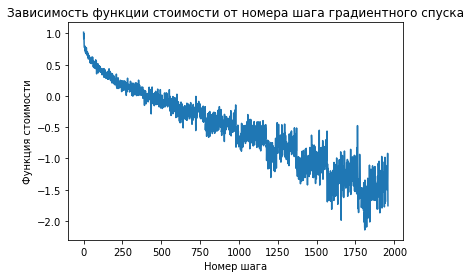

In [ ]:
# Готовимся к обучению
model = ConvNet().to(device)  # создаем модель
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # оптимизатор, нужно выбрать и настроить
loss_function = nn.CrossEntropyLoss()  # функция потерь, нужно выбрать
loss_history = list()  # список для хранения истории изменения функции стоимости

# Начинаем обучение
for epoch in range(EPOCHS):
  for i, (batch, labels) in enumerate(train_loader):  # разбиваем выборку на пакеты
    # Нужно реализовать один шаг градиентного спуска
    loss = torch.tensor(0, dtype=torch.float32)  # значение функции стоимости на пакете, нужно рассчитать
    # ВАШ КОД ЗДЕСЬ
    batch, labels = batch.to(device), labels.to(device)
    optimizer.zero_grad()
    loss = loss_function(model(batch), labels.to(device))
    loss.backward()
    optimizer.step()
    # ===============
    loss_history.append(loss.log().item())  # добавляется логарифм стоимости для большей наглядности
  print(f'Эпоха {epoch + 1} завершилась с функцией стоимости на последнем пакете = {loss.item()}')


# Выводим график функции стоимости
plt.title('Зависимость функции стоимости от номера шага градиентного спуска')
plt.xlabel('Номер шага')
plt.ylabel('Функция стоимости')
plt.plot(loss_history)
plt.show()

In [ ]:
torch.cuda.empty_cache()
# Отключаем расчет вычислительного графа для экономии времени и памяти: нам не нужно считать градиенты при тестировании модели
with torch.no_grad():
  # Оцениваем качество модели
  train_data_loader = DataLoader(train_data, batch_size=256)
  accuracy_lst = []
  for batch, labels in train_data_loader:
    batch, labels = batch.cuda(), labels.cuda()
    prediction = torch.argmax(model(batch), dim=1)
    accuracy_lst.append((labels == prediction).type(torch.float32).mean().item())
  print('Точность (accuracy) на обучающей выборке:', sum(accuracy_lst)/len(accuracy_lst))

with torch.no_grad():
  # Оцениваем качество модели
  test_data_loader = DataLoader(test_data, batch_size=len(test_data))
  test_features, test_targets = next(iter(test_data_loader))

  test_features = test_features.to(device)
  test_model_predictions = torch.argmax(model(test_features), dim=1)
  print('Точность (accuracy) на тестовой выборке:', accuracy_score(test_data.targets, test_model_predictions.detach().cpu().numpy()))

Точность (accuracy) на обучающей выборке: 0.9485730230808258
Точность (accuracy) на тестовой выборке: 0.7842


##### дальше поломано

In [ ]:
# # Отключаем расчет вычислительного графа для экономии времени и памяти: нам не нужно считать градиенты при тестировании модели
# torch.cuda.empty_cache()
# with torch.no_grad():
#     # Оцениваем качество модели
#     train_data_loader = DataLoader(train_data, batch_size=len(train_data))
#     train_features, train_targets = next(iter(train_data_loader))

#     train_features = train_features.to(device)
#     train_model_predictions = torch.argmax(model(train_features), dim=1).cpu()
#     print('Точность (accuracy) на обучающей выборке:', accuracy_score(train_data.targets, train_model_predictions.cpu()))

#     test_data_loader = DataLoader(test_data, batch_size=len(test_data))
#     test_features, test_targets = next(iter(test_data_loader))

#     test_features = test_features.to(device)
#     test_model_predictions = torch.argmax(model(test_features), dim=1)
#     print('Точность (accuracy) на тестовой выборке:', accuracy_score(test_data.targets, test_model_predictions.cpu()))

RuntimeError: ignored